In [2]:
import pandas as pd
from tensorflow.keras.utils import get_file
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from scipy.stats import zscore
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import Normalizer
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Lambda
from keras.layers import Embedding
from keras.layers import Convolution1D,MaxPooling1D, Flatten
from keras.datasets import imdb
from keras import backend as K
import pandas as pd
from keras.models import Sequential
from keras.layers import Convolution1D, Dense, Dropout, Flatten, MaxPooling1D
from keras.utils import np_utils
import numpy as np
import h5py
from keras import callbacks
from keras.layers import LSTM, GRU, SimpleRNN
from keras.callbacks import CSVLogger
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

In [3]:
pd.set_option('display.max_columns', 6)
pd.set_option('display.max_rows', 5)

try:
    path = get_file('kdd-with-columns.csv', origin=\
    'https://github.com/jeffheaton/jheaton-ds2/raw/main/'\
    'kdd-with-columns.csv',archive_format=None)
except:
    print('Error downloading')
    raise
    
print(path) 

# Origional file: http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html
df = pd.read_csv(path)

print("Read {} rows.".format(len(df)))
# df = df.sample(frac=0.1, replace=False) # Uncomment this line to 
# sample only 10% of the dataset
df.dropna(inplace=True,axis=1) 
# For now, just drop NA's (rows with missing values)

68141056/68132668 [==============================] - 1s 0us/step
/root/.keras/datasets/kdd-with-columns.csv
Read 494021 rows.


In [4]:
# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd
    
# Encode text values to dummy variables(i.e. [1,0,0],
# [0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = f"{name}-{x}"
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

# Now encode the feature vector

pd.set_option('display.max_columns', 6)
pd.set_option('display.max_rows', 5)

for name in df.columns:
  if name == 'outcome':
    pass
  elif name in ['protocol_type','service','flag','land','logged_in',
                'is_host_login','is_guest_login']:
    encode_text_dummy(df,name)
  else:
    encode_numeric_zscore(df,name)    

# display 5 rows

df.dropna(inplace=True,axis=1)
df[0:5]


# Convert to numpy - Classification
x_columns = df.columns.drop('outcome')
x = df[x_columns].values
dummies = pd.get_dummies(df['outcome']) # Classification
outcomes = dummies.columns
num_classes = len(outcomes)
y = dummies.values

In [5]:
df.groupby('outcome')['outcome'].count()

outcome
back.               2203
buffer_overflow.      30
                    ... 
warezclient.        1020
warezmaster.          20
Name: outcome, Length: 23, dtype: int64

In [6]:
import pandas as pd
import io
import requests
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping

# Create a test/train split.  25% test
# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.25, random_state=42)

In [8]:

lstm_output_size = 70

cnn = Sequential()
cnn.add(Convolution1D(64, 2,activation="relu",input_shape=(120, 1)))
cnn.add(MaxPooling1D(pool_size=(2)))
cnn.add(LSTM(lstm_output_size))
cnn.add(Dropout(0.1))
cnn.add(Dense(23, activation="softmax"))

# define optimizer and objective, compile cnn

cnn.compile(loss="categorical_crossentropy", optimizer="adam",metrics=['accuracy'])

# train
checkpointer = callbacks.ModelCheckpoint(filepath="checkpoint/cnnlstm/checkpoint-{epoch:02d}.hdf5", verbose=1,save_best_only=True, monitor='accuracy',mode='max')
csv_logger = CSVLogger('logs/cnnlstm.csv',separator=',', append=False)
cnn.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test),callbacks=[checkpointer,csv_logger])


Epoch 1/50
11578/11579 [============================>.] - ETA: 0s - loss: 0.0749 - accuracy: 0.9802
Epoch 1: accuracy improved from -inf to 0.98020, saving model to checkpoint/cnnlstm/checkpoint-01.hdf5
11579/11579 [==============================] - 619s 53ms/step - loss: 0.0749 - accuracy: 0.9802 - val_loss: 0.0177 - val_accuracy: 0.9955
Epoch 2/50
11578/11579 [============================>.] - ETA: 0s - loss: 0.0156 - accuracy: 0.9960
Epoch 2: accuracy improved from 0.98020 to 0.99601, saving model to checkpoint/cnnlstm/checkpoint-02.hdf5
11579/11579 [==============================] - 613s 53ms/step - loss: 0.0156 - accuracy: 0.9960 - val_loss: 0.0115 - val_accuracy: 0.9968
Epoch 3/50
11578/11579 [============================>.] - ETA: 0s - loss: 0.0105 - accuracy: 0.9973
Epoch 3: accuracy improved from 0.99601 to 0.99731, saving model to checkpoint/cnnlstm/checkpoint-03.hdf5
11579/11579 [==============================] - 608s 52ms/step - loss: 0.0105 - accuracy: 0.9973 - val_loss: 0

KeyboardInterrupt: ignored

In [9]:
cnn.save("results/cnnlstm/cnnlstm_model.hdf5")

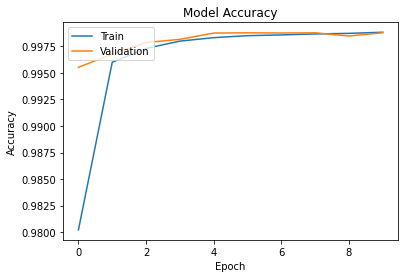

In [10]:
plt.plot(cnn.history.history['accuracy'])
plt.plot(cnn.history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

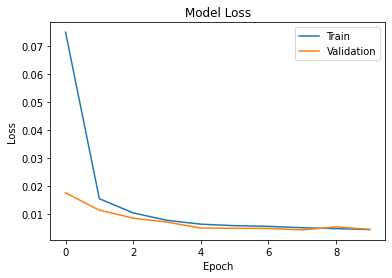

In [11]:
plt.plot(cnn.history.history['loss'])
plt.plot(cnn.history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()